# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 1 contains 5 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number : 25

## Student 1 
### Name : Aditya Kunar
### ID :

## Student 2
### Name : Anwesh Marwade
### ID : 5052068

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re

## Preprocess

In [2]:
# Apply currency conversion so that the amounts are standardized
def conv(row):
    currency_dict = {0: 0.86248, 1: 1.5911, 2: 21.2829, 3: 1.6805, 4: 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

def preprocess(df):
    df1 = df.copy(deep=True)
    df1 = df1.loc[~(df1['simple_journal'] == 'Refused')]
    df1.loc[df1['simple_journal'] == 'Chargeback', 'simple_journal'] = 1 #fraud
    df1.loc[df1['simple_journal'] == 'Settled', 'simple_journal'] = 0

    df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
    df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
    df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

    bin_enc = LabelEncoder()
    bin_enc.fit(df1['bin'].unique())
    df1['bin'] = bin_enc.transform(df1.bin)


    card_enc = LabelEncoder()
    card_enc.fit(df1['card_id'])
    df1['card_id'] = card_enc.transform(df1.card_id)

    ip_enc = LabelEncoder()
    ip_enc.fit(df1['ip_id'])
    df1['ip_id'] = ip_enc.transform(df1.ip_id)

    df1['creationdate'] = pd.to_datetime(df1['creationdate'])
    df1['date'] = df1['creationdate'].dt.date

    unique_issuer_cc = df1['issuercountrycode'].unique()
    unique_shopper_cc = df1['shoppercountrycode'].unique()
    both = np.append(unique_issuer_cc, unique_shopper_cc)
    df_countrycodes = pd.DataFrame(both)
    unique_codes = df_countrycodes[0].unique()
    enc = LabelEncoder()
    enc.fit(unique_codes)
    df1['issuercountrycode'] = enc.transform(df1.issuercountrycode)
    df1['shoppercountrycode'] = enc.transform(df1.shoppercountrycode)
    
#     df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)

    enc1 = LabelEncoder()
    enc1.fit(df1['txvariantcode'])
    df1['txvariantcode'] = enc1.transform(df1.txvariantcode)

    enc2 = LabelEncoder()
    enc2.fit(df1['currencycode'])
    df1['currencycode'] = enc2.transform(df1.currencycode)

    enc3 = LabelEncoder()
    enc3.fit(df1['shopperinteraction'])
    df1['shopperinteraction'] = enc3.transform(df1.shopperinteraction)

    df1['accountcode'] = df1['accountcode'].apply(lambda x: re.sub('Account','',x))
    df1['accountcode_cc'] = 0
    df1.loc[(df1['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
    df1.loc[(df1['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
    df1.loc[(df1['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
    df1.loc[(df1['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

    enc4 = LabelEncoder()
    enc4.fit(df1['accountcode'])
    df1['accountcode'] = enc4.transform(df1.accountcode)

    enc5 = LabelEncoder()
    enc5.fit(df1['cardverificationcodesupplied'])
    df1['cardverificationcodesupplied'] = enc5.transform(df1.cardverificationcodesupplied)

    df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

    enc6 = LabelEncoder()
    enc6.fit(df1['mail_id'])
    df1['mail_id'] = enc6.transform(df1.mail_id)

    df1['bookingdate'] = pd.to_datetime(df1['bookingdate'])

    df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

    df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
    df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
    df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

    df1['day_of_week'] = df1['creationdate'].dt.dayofweek

    df1['hour'] = df1['creationdate'].dt.hour
    
    return df1

def conv_creationdate(df1):
    dates= df1["creationdate"]
    dates=pd.DatetimeIndex(dates)
    dates=dates.astype(np.int64) // 10**9
    df1['creationdate']=dates
    return df1

## Parse Data into Dataframe

In [3]:
data = "data_for_student_case.csv"
df = pd.read_csv(data)

prep_df = preprocess(df)
# Convert creationdate
prep_df = conv_creationdate(prep_df)

## 1. Visualization task – 1 A4

### 1a. Plot visulations 

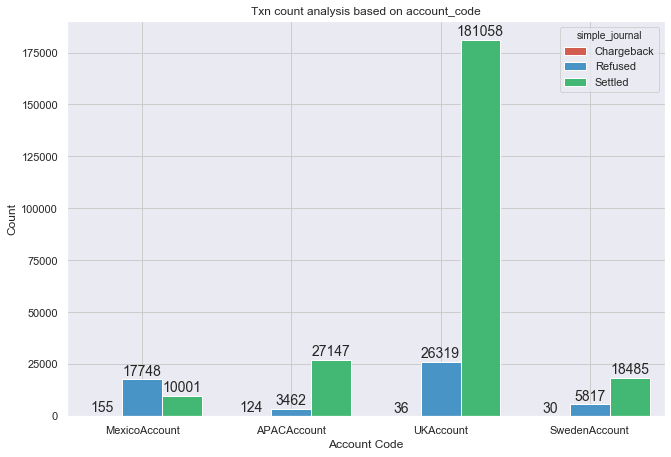

In [4]:
# Visualization 1
sns.set(rc={'figure.figsize':(10.7,7.27)})
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="accountcode", hue="simple_journal", data=df, palette=flatui)
ax.set_title('Txn count analysis based on account_code')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Account Code')
max_height = 0

for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height),
            ha="center",size=14)

### 1b. Describe the visualizations and provide relavant explanations of features and relations.

## 2. Imbalance task – 1 A4 – Individual

### SMOTE implementation with optional tomek link removal

In [7]:
import random
import math

# for tomek links implementation
from sklearn.neighbors import NearestNeighbors

'''
Function to find the k nearest neighbours
'''
def k_neighbors(curr_row, data, k):
    dist_list = list()
    for idx in range(len(data)):
        dist = euclidean_distance(curr_row, data[idx])
        dist_list.append((idx, dist))
        
    dist_list.sort(key=lambda tup: tup[1])
    k_neighbours = list()
    
    for i in range(k):
        k_neighbours.append(dist_list[i][0])
        
    return k_neighbours
    
'''
Calculate the Euclidean distance between two vectors
'''
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)):
        distance = distance + (row1[i] - row2[i])**2
    return math.sqrt(distance)

'''
SMOTE function:
    T => Number of minority Samples available
    N => No. synthetic samples to be generated (in % of T)
    k => No. of nearest neighbours to be considered
    returns a list of synthetic samples
'''
def smote(T,N,k,minority_samples):
    
# if N < 100, sample from random percent of minority instances
    if N < 100:
        T = (N/100) * T
        N = 100 # since we changed T now, make N = 100
        
# N controls the number of synthetic samples generated per data point
    N = (int)(N/100)
    synthetic_samples = list()
    
    for i in range(T):
        counter = N
# If k = 0, the nearest neighbour is the point itself.
        if(k):
            nn_list = k_neighbors(minority_samples[i], minority_samples, k)
        else:
            rand_knbr = i
        while counter:
            rand_nn = random.randint(1, len(nn_list) - 1)
            rand_knbr = nn_list[rand_nn]
            sample_row = []
            for attr in range(len(minority_samples[i])):
                diff = minority_samples[rand_knbr][attr] - minority_samples[i][attr]
                rand_gap = random.uniform(0, 1)
                sample_row.append(int(minority_samples[i][attr] + rand_gap*diff))
            synthetic_samples.append    
            synthetic_samples.append(sample_row)
            counter = counter - 1
    
    return synthetic_samples

'''
Wrapper for the SMOTE function:
default tomek_link = False (links are not removed)
    N => No. synthetic samples to be generated (in % of T)
    k => No. of nearest neighbours to be considered
    tomek_links => True: remove tomek_links, False: do not remove
'''
def smote_wrapper(prep_df, N, k, tomek_links = False):
    
# Drop these columns from the parent df
    df1 = prep_df.copy()
    df1.drop(columns=['txid','bookingdate','date','accountcode_cc'], inplace=True)
    
# Separate out the fraud and non-fraud instances
    not_fraud_df = df1.loc[df1["simple_journal"] == 0]
    fraud_df = df1.loc[df1['simple_journal'] == 1]
    minority_samples = np.array(fraud_df)
    
# Generate 'N%' new synthetic samples condsidering 'k' nearest neighbours
    synthetic_fraud_df = pd.DataFrame(smote(len(minority_samples), N, k, minority_samples),
                                      columns=['issuercountrycode', 'txvariantcode', 'bin', 'amount', 'currencycode',
       'shoppercountrycode', 'shopperinteraction', 'simple_journal',
       'cardverificationcodesupplied', 'cvcresponsecode', 'creationdate',
       'accountcode', 'mail_id', 'ip_id', 'card_id', 'countries_equal',
       'day_of_week', 'hour'])  
    
    aug_fraud_df = pd.concat([fraud_df, synthetic_fraud_df])
    full_df = pd.concat([aug_fraud_df, not_fraud_df])
    
    
# Tomek Links
    len_fraud = len(aug_fraud_df.values)
    if(tomek_links):
        remove_idx=[]
        full_df_mat = full_df.values
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(full_df_mat)
        distances, indices = nbrs.kneighbors(full_df_mat[:len_fraud])
        for i in indices:
            if any(idx > len_fraud for idx in i):
                remove_idx.append(i[0])
        needed = list(set(np.arange(len_fraud)) - set(remove_idx))
        aug_fraud_df = pd.DataFrame([aug_fraud_df.iloc[i] for i in needed])
        full_df = pd.concat([aug_fraud_df, not_fraud_df])
        
    full_df['amount_eur'] = full_df.apply(lambda x: conv(x), axis=1)
    return full_df

### Apply SMOTE

In [8]:
# 200% samples with 2 nearest neighbours
# Tomek Links not removed if tomek_links is set to false
smoted_df = smote_wrapper(prep_df, N = 500, k = 2, tomek_links = False)
smoted_df['simple_journal'].value_counts()

0    236691
1      2070
Name: simple_journal, dtype: int64

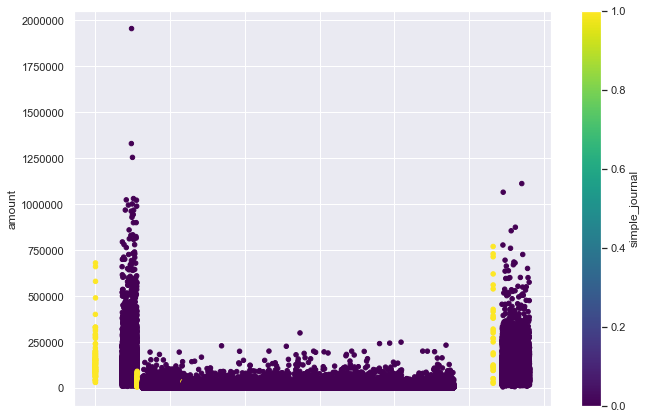

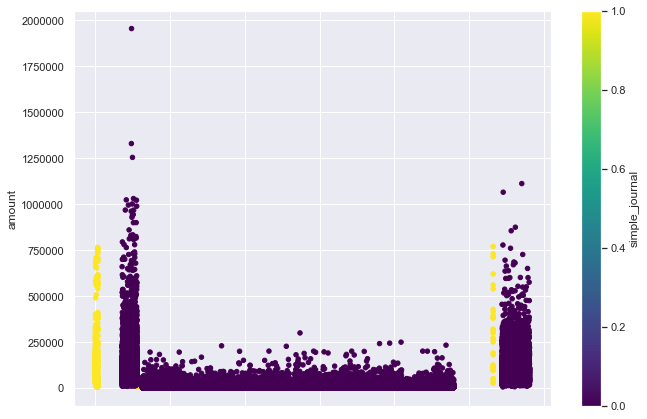

In [9]:
# Scatter Plots to visualize the SMOTE results
ax1 = prep_df.reset_index().plot.scatter(x='index', y='amount', c='simple_journal', colormap='viridis')
ax2 = smoted_df.reset_index().plot.scatter(x='index', y='amount', c='simple_journal', colormap='viridis')

### 2a. Print ROC curves

#### Train Classifiers

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn import metrics

from sklearn import svm


X = prep_df.drop(['simple_journal', 'accountcode_cc', 'txid', 'bookingdate', 'date'], axis=1)
y = prep_df.drop(['accountcode_cc', 'txid', 'bookingdate', 'date'], axis=1)['simple_journal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" %(X_test.shape[0], (y_test != y_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred))

y_pred_proba = gnb.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

X = smoted_df.drop(['simple_journal'], axis=1)
y = smoted_df['simple_journal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" %(X_test.shape[0], (y_test != y_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred))

y_pred_proba_smote = gnb.predict_proba(X_test)[::,1]
fpr_smote, tpr_smote, thresholds_smote = metrics.roc_curve(y_test, y_pred_proba_smote)
auc_smote = metrics.roc_auc_score(y_test, y_pred_proba_smote)

Number of mislabeled points out of a total 47408 points : 617
accuracy:  0.9869853189335134
Number of mislabeled points out of a total 47753 points : 992
accuracy:  0.9792264360354324


#### Plot ROC Curves

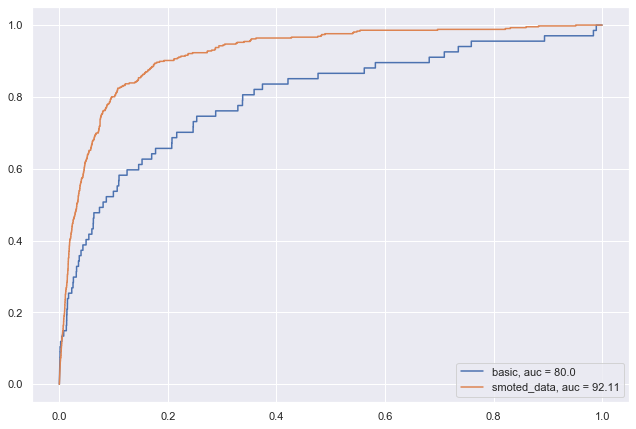

In [11]:
# AUC curve
# X_train.shape

plt.plot(fpr, tpr, label="basic, auc = " +str(round(auc*100,2)))
plt.plot(fpr_smote, tpr_smote, label = "smoted_data, auc = "+str(round(auc_smote*100,2)))
plt.legend(loc=4)
plt.show()

### 2b. Analyse the performance of the classifiers. Explain which method performs best.

### 2c. Is using SMOTE a good idea? Why (not)?

## 3. Privacy task – 1 A4 – Individual

### 3a. Print ROC curves

### 3b. Analyse the performance of the classifiers. Explain which method performs best.

### 3c. Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

## 4. Classification task – 2 A4

### 4a. Print relevant plots and metrics with clear headings.

### 4b. Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

## 5. Bonus task – 1 A4

### 5a. Provide code and report below